In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import bambi as bmb
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact
import ipywidgets as ipyw
import pymc as pm

In [2]:
plt.style.use('arviz-doc')

# Bambi
- Designed to make easy to fit linear models, including hierarchical ones
- Defines weakly informative priors
- Auxiliary parameters: Not modeled directly
- Common level effects

In [3]:
SIZE = 117
data = pd.DataFrame(
    {
        "y": np.random.normal(size=SIZE),
        "x": np.random.normal(size=SIZE),
        "z": np.random.normal(size=SIZE),
        "g": ["Group A", "Group B", "Group C"] * 39,
    }
)
data.head()

,y,x,z,g
0,0.566987,-0.499945,-0.320164,Group A
1,0.173932,2.182753,-0.026084,Group B
2,0.187911,0.533322,0.526489,Group C
3,-0.789294,0.330210,0.889179,Group A
4,-0.216600,0.694837,0.976625,Group B


In [4]:
with pm.Model() as lm:
    Intercept = pm.Normal("Intercept", 0, 1)
    x = pm.Normal("x", 0, 1)
    y_sigma = pm.HalfNormal("sigma", 1)
    y_mean = Intercept + x * data["x"]
    y = pm.Normal("y", y_mean, y_sigma, observed=data["y"])

In [5]:
# Using bambi
model = bmb.Model("y ~ x",data)
model

       Formula: y ~ x
        Family: gaussian
          Link: mu = identity
  Observations: 117
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: -0.0108, sigma: 2.2832)
            x ~ Normal(mu: 0.0, sigma: 2.3278)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.9102)

In [6]:
without_intercept = bmb.Model("y ~ 0 + x", data)
without_intercept

       Formula: y ~ 0 + x
        Family: gaussian
          Link: mu = identity
  Observations: 117
        Priors: 
    target = mu
        Common-level effects
            x ~ Normal(mu: 0.0, sigma: 2.3278)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.9102)

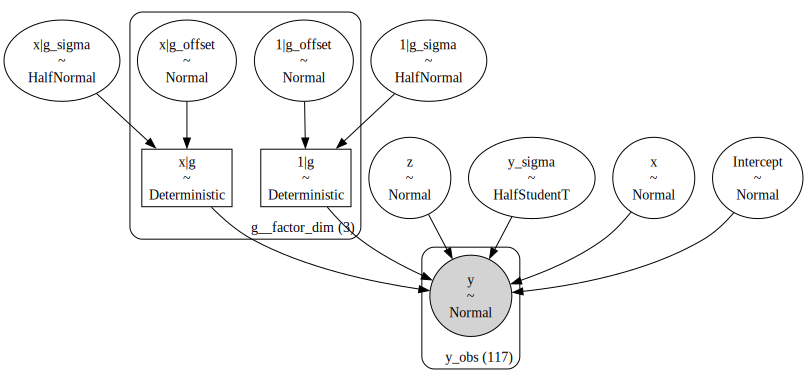

In [7]:
## Group level effects
hierarc_m = bmb.Model("y ~ x + z + (x | g)", data) 
hierarc_m.build()
hierarc_m.graph()

## Example 1

In [8]:
bikes = pd.read_csv("data/bicis.csv")
model1 = bmb.Model("alquiladas ~ temperatura",bikes,family='negativebinomial')
idata_model1 = model1.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alquiladas_alpha, Intercept, temperatura]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 25 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


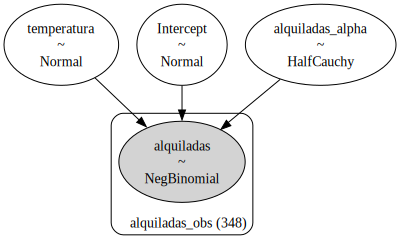

In [9]:
model1.graph()

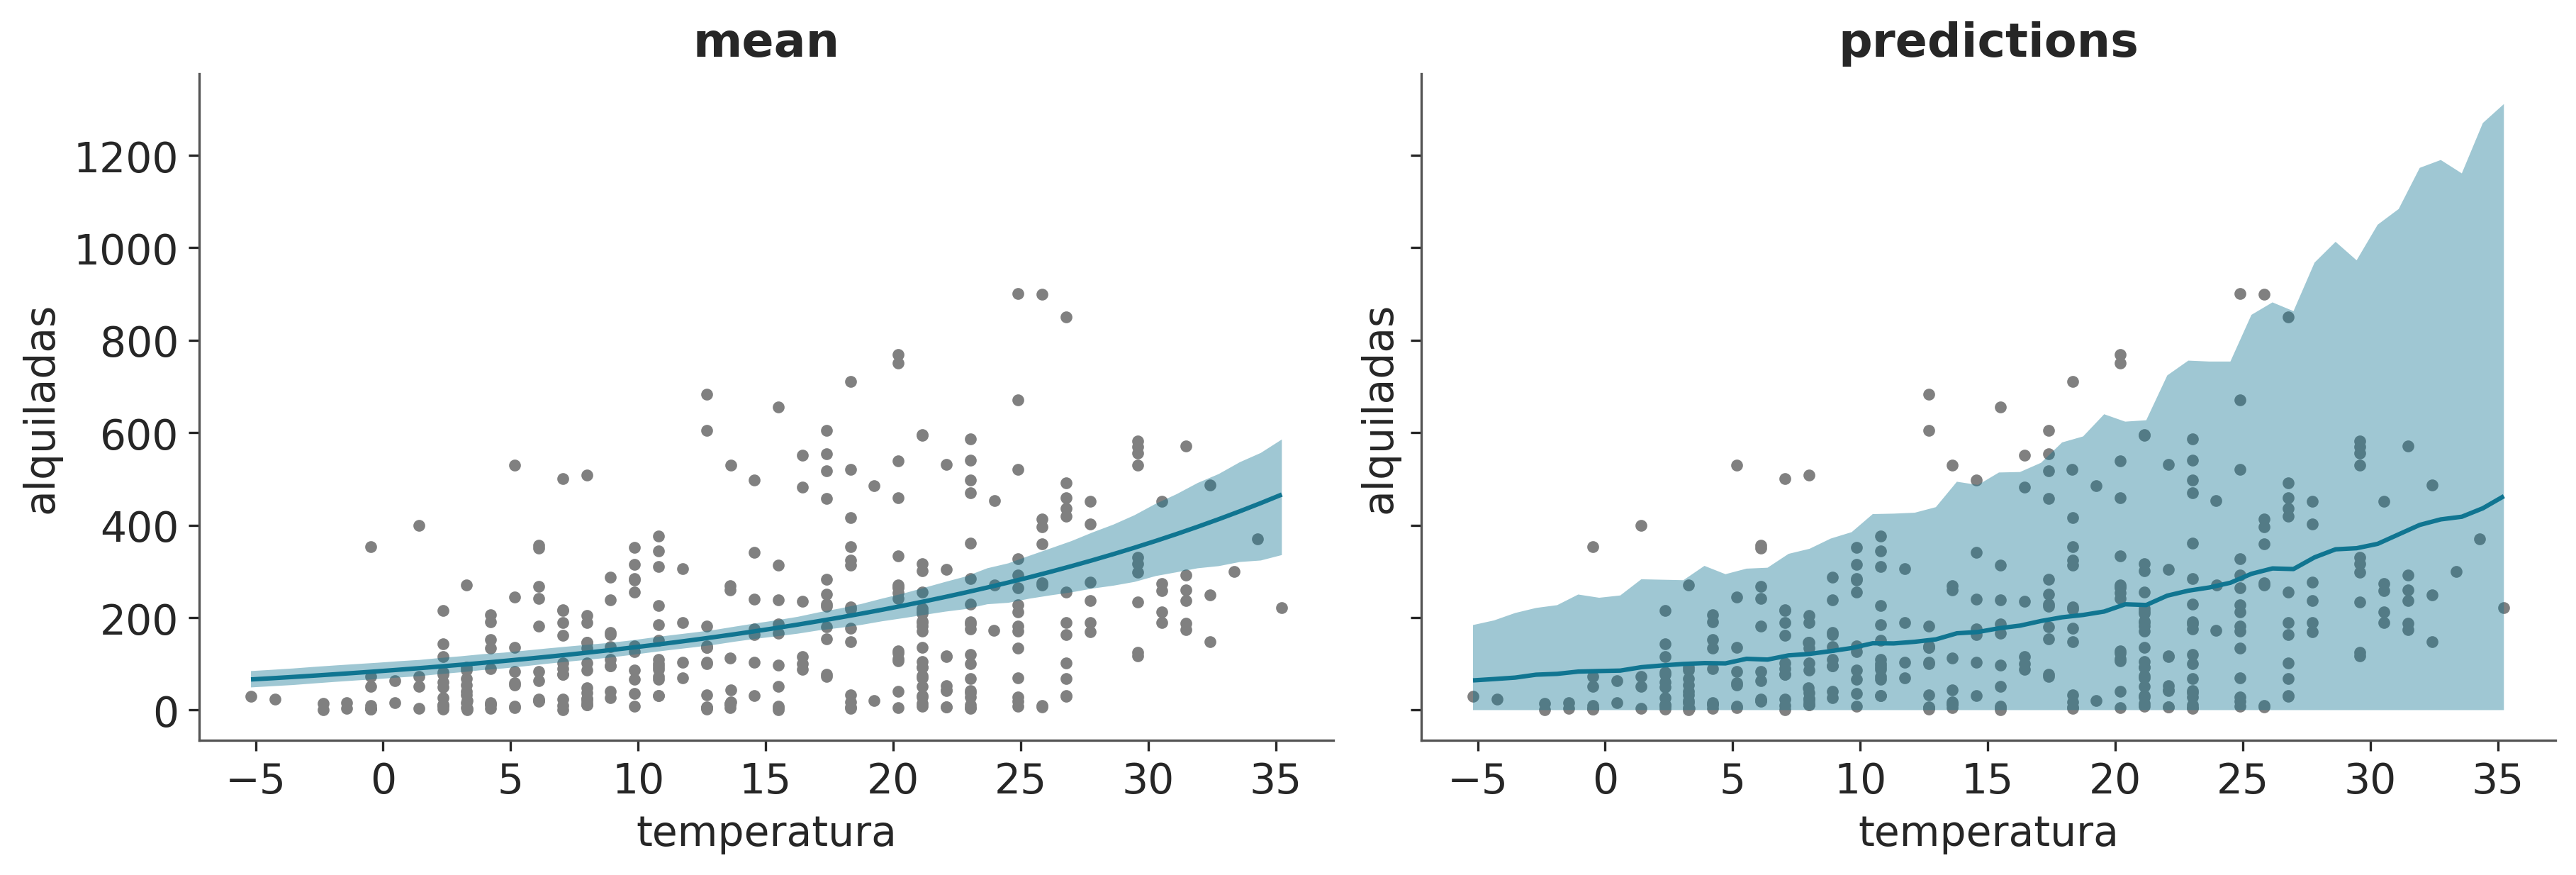

In [10]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 4)) 
bmb.interpret.plot_predictions(model1, idata_model1, "temperatura", ax=axes[0])
bmb.interpret.plot_predictions(model1, idata_model1, "temperatura", pps=True, ax=axes[1])

axes[0].plot(bikes.temperatura, bikes.alquiladas, ".", color="0.5",  zorder=-3)
axes[1].plot(bikes.temperatura, bikes.alquiladas, ".", color="0.5", zorder=-3)
axes[0].set_title("mean")
axes[1].set_title("predictions");

## Polynomial regression
- Two ways to write
  - "y ~ x + I(x ** 2) + I(x ** 3) + I(x ** 4)"
  - "y ~ poly(x, 4)", but the terms in the polynomial will be orthogonal to each other
    - May be more numerically stable
    - Interpretation for the coefficients change
      - Allows to interpret effect of each coefficient, since they are orthogonal
  - Same predictions with both approaches
- Polynomials make linear models more prone to overfitting
- Bayesian suffers a little less, with the use of priors and not calculating a point estimate per coefficient

In [11]:
poly4_model = bmb.Model("alquiladas ~ poly(hora, degree=4)", bikes,
                       family="negativebinomial")
idata_poly4 = poly4_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alquiladas_alpha, Intercept, poly(hora, degree=4)]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 33 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Text(0, 0.5, '')

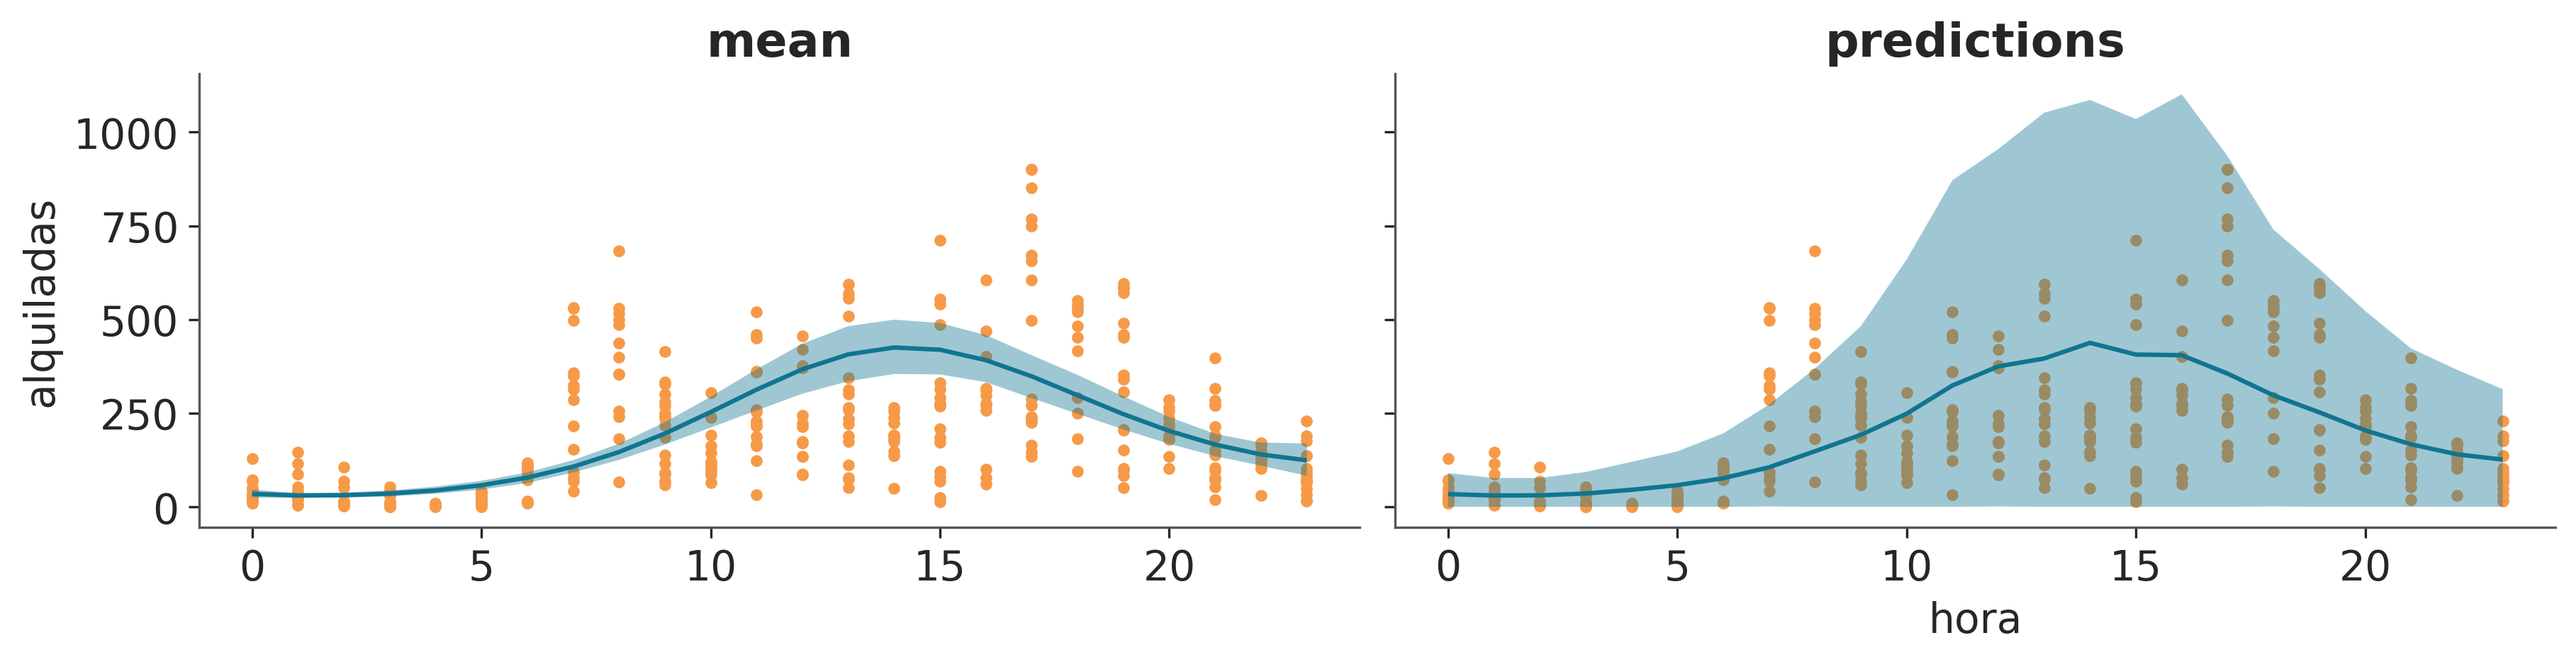

In [12]:
_, axes = plt.subplots(1, 2, sharey=True, sharex="col", figsize=(12, 3)) 
bmb.interpret.plot_predictions(poly4_model, idata_poly4, "hora", ax=axes[0])
bmb.interpret.plot_predictions(poly4_model, idata_poly4, "hora", pps=True, ax=axes[1])

for ax in axes.ravel():
    ax.plot(bikes.hora, bikes.alquiladas, "C2.", zorder=-3)
axes[0].set_title("mean")
axes[1].set_title("predictions")
axes[0].set_xlabel("")
axes[1].set_ylabel("")

## Splines
$$\mu = \beta_{0} + \beta_{1}B1(X1)...$$
- with $B$ being a function
- Splines: Way to increase flexibility, but less prone to overfit than polynomials
- Knots: Points that constrain regions
- Ways to choose splines
  - nodes = np.quantile(bikes.hora,np.linspace(0,1,num_knots)). More nodes in ammount where there is more data. Adaptative approach
  - Using cross-validation like methods

In [15]:
num_knots = 6 # 6 splines, each of degree  3
knots = np.linspace(0, 23, num_knots+2)[1:-1]
print(knots)
spline_model = bmb.Model("alquiladas ~ bs(hora, degree=3, knots=knots)", bikes,           
                         family="negativebinomial")
idata_spline = spline_model.fit()

[ 3.28571429  6.57142857  9.85714286 13.14285714 16.42857143 19.71428571]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alquiladas_alpha, Intercept, bs(hora, degree=3, knots=knots)]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 33 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


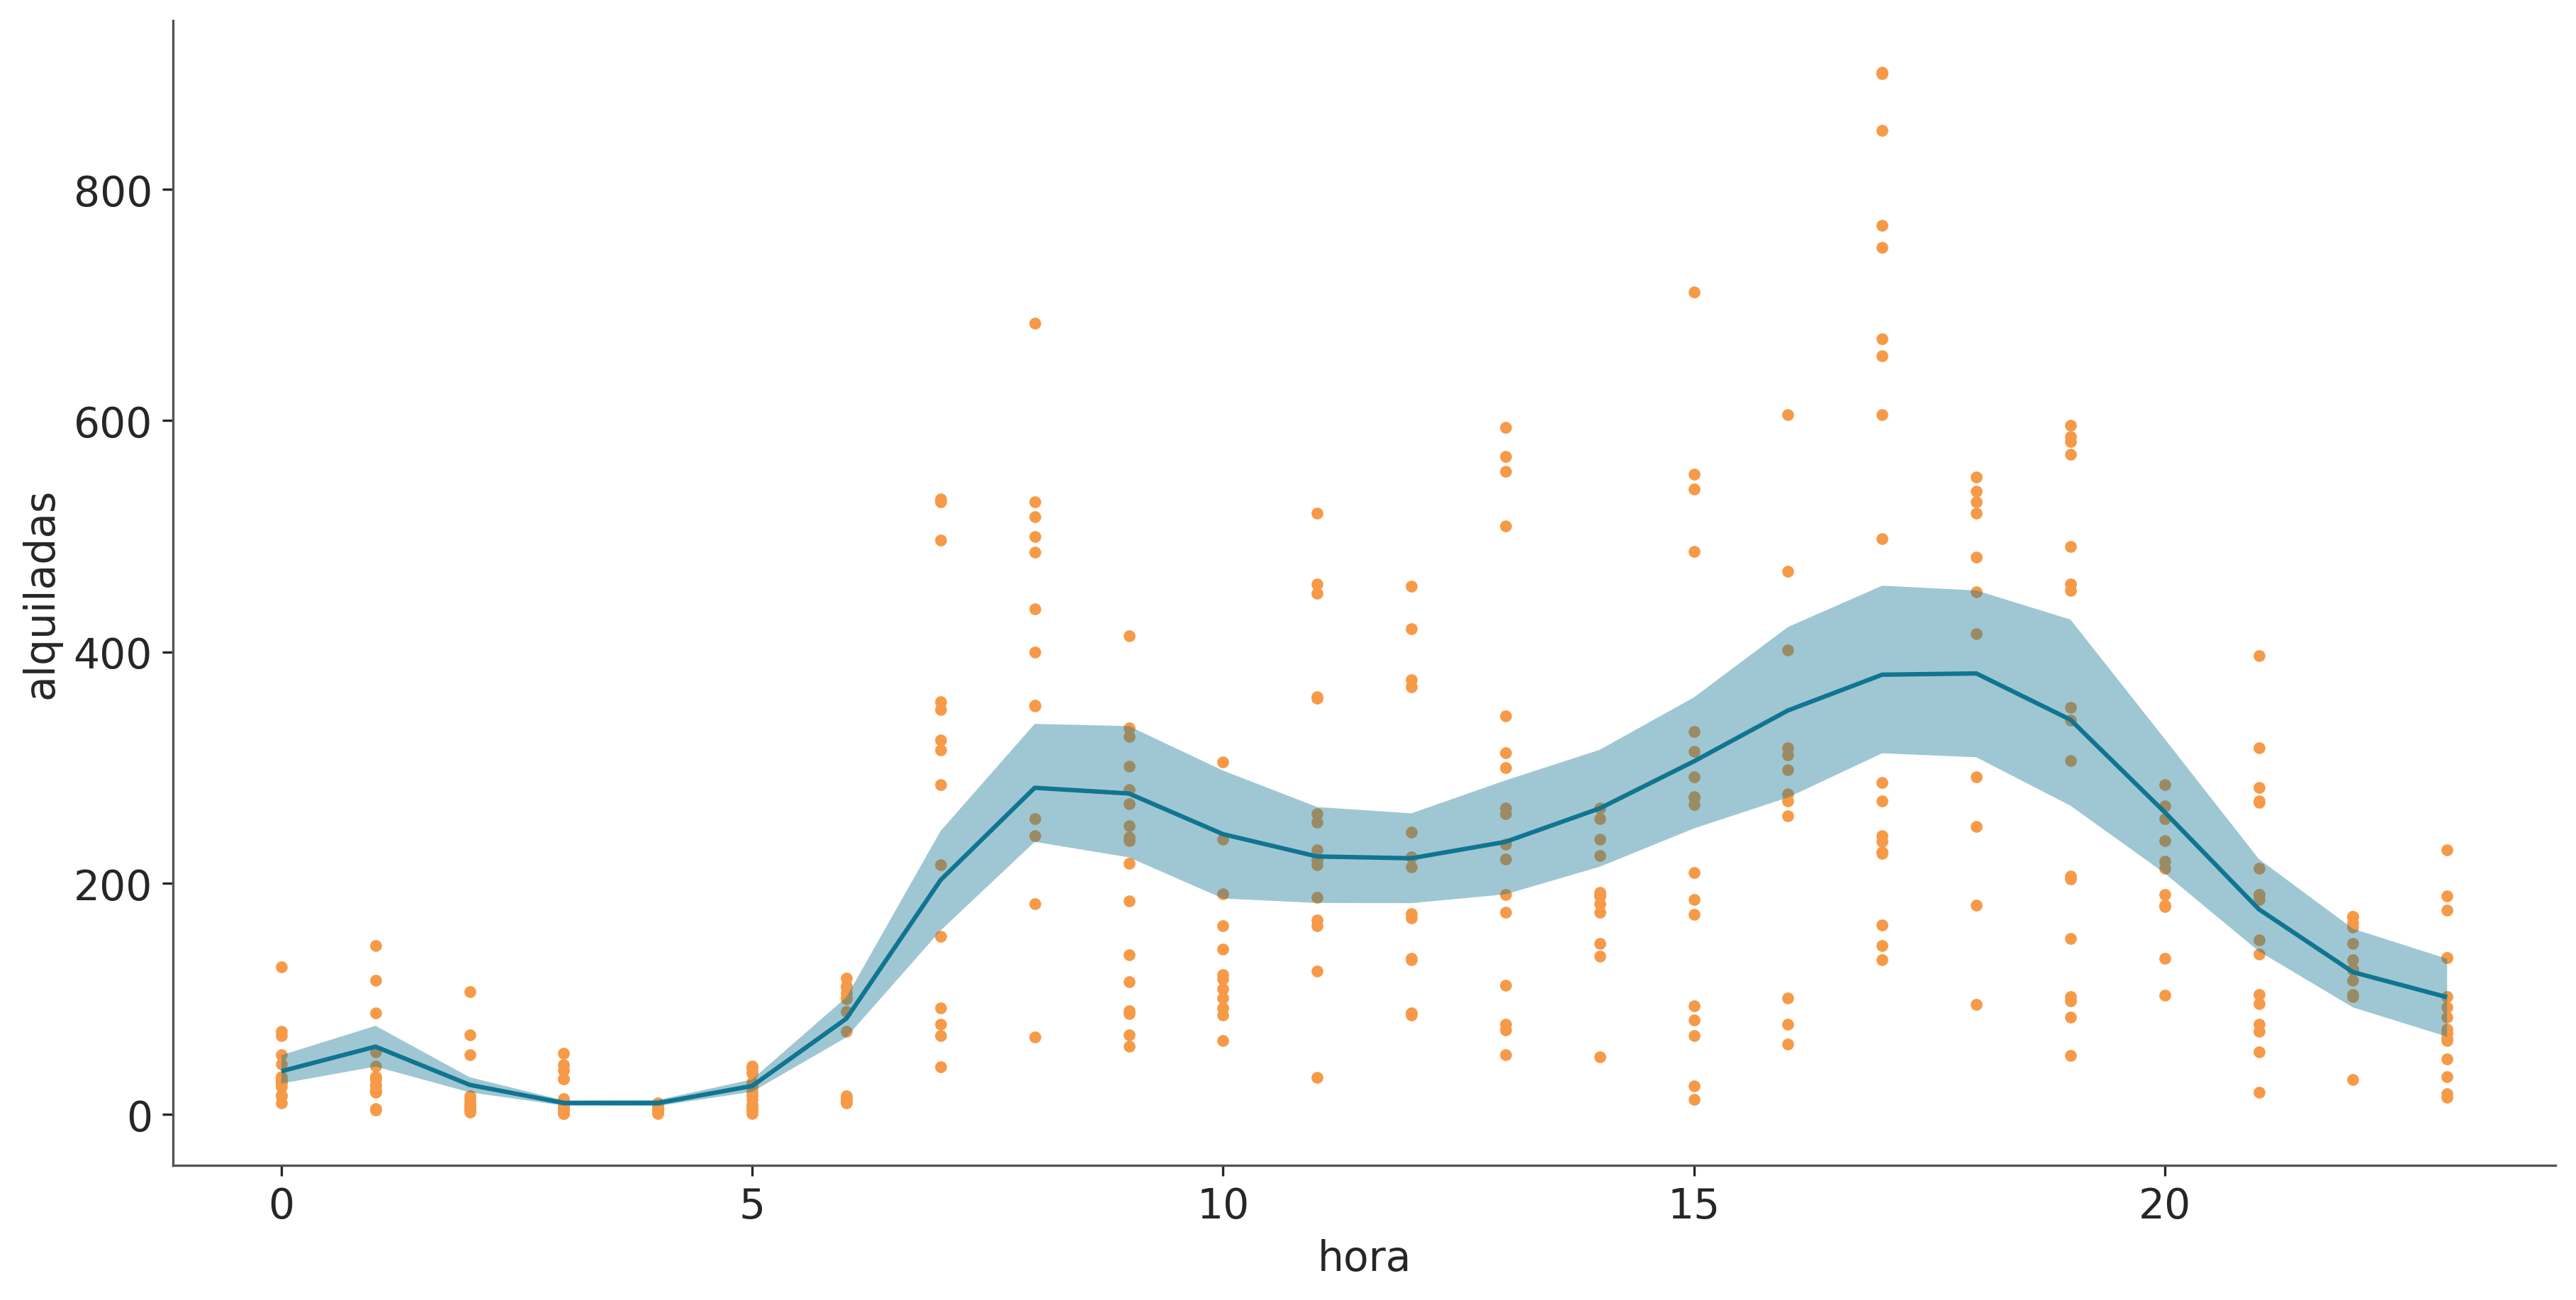

In [16]:
_, ax = plt.subplots(sharey=True, sharex="col", figsize=(12, 6)) 
bmb.interpret.plot_predictions(spline_model, idata_spline, "hora", ax=ax)
ax.plot(bikes.hora, bikes.alquiladas, "C2.", zorder=-3)

## Distributional models
- Model more than one parameter of the distribution
- 

In [18]:
babies = pd.read_csv('data/babies.csv')
modelo_cons = bmb.Model("Longitud ~ np.sqrt(Meses)", babies)
idata_cons = modelo_cons.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Longitud_sigma, Intercept, np.sqrt(Meses)]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 23 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [19]:
formula = bmb.Formula(
    "Longitud ~ np.sqrt(Meses)",
    "sigma ~ Meses" # Sigma as a linear function of months
)
modelo_dis = bmb.Model(formula, babies)
idata_dis = modelo_dis.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, np.sqrt(Meses), sigma_Intercept, sigma_Meses]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 25 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [20]:
modelo_dis.predict(idata_dis, kind="pps", data=pd.DataFrame({"Meses":[0.5]}))


In [21]:
idata_dis

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

## Categorical Predictors
- body_mass ~ bill_length|species Slope and intercept for each species 
- body_mass ~ (0 + bill_length | specie) only slope for each species

In [23]:
penguins = pd.read_csv("data/penguins.csv").dropna()
penguins_model = bmb.Model("body_mass ~ bill_length + species", data=penguins) # Bambi encodes categorical variables as n-1
idata_p = penguins_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [body_mass_sigma, Intercept, bill_length, species]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 32 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


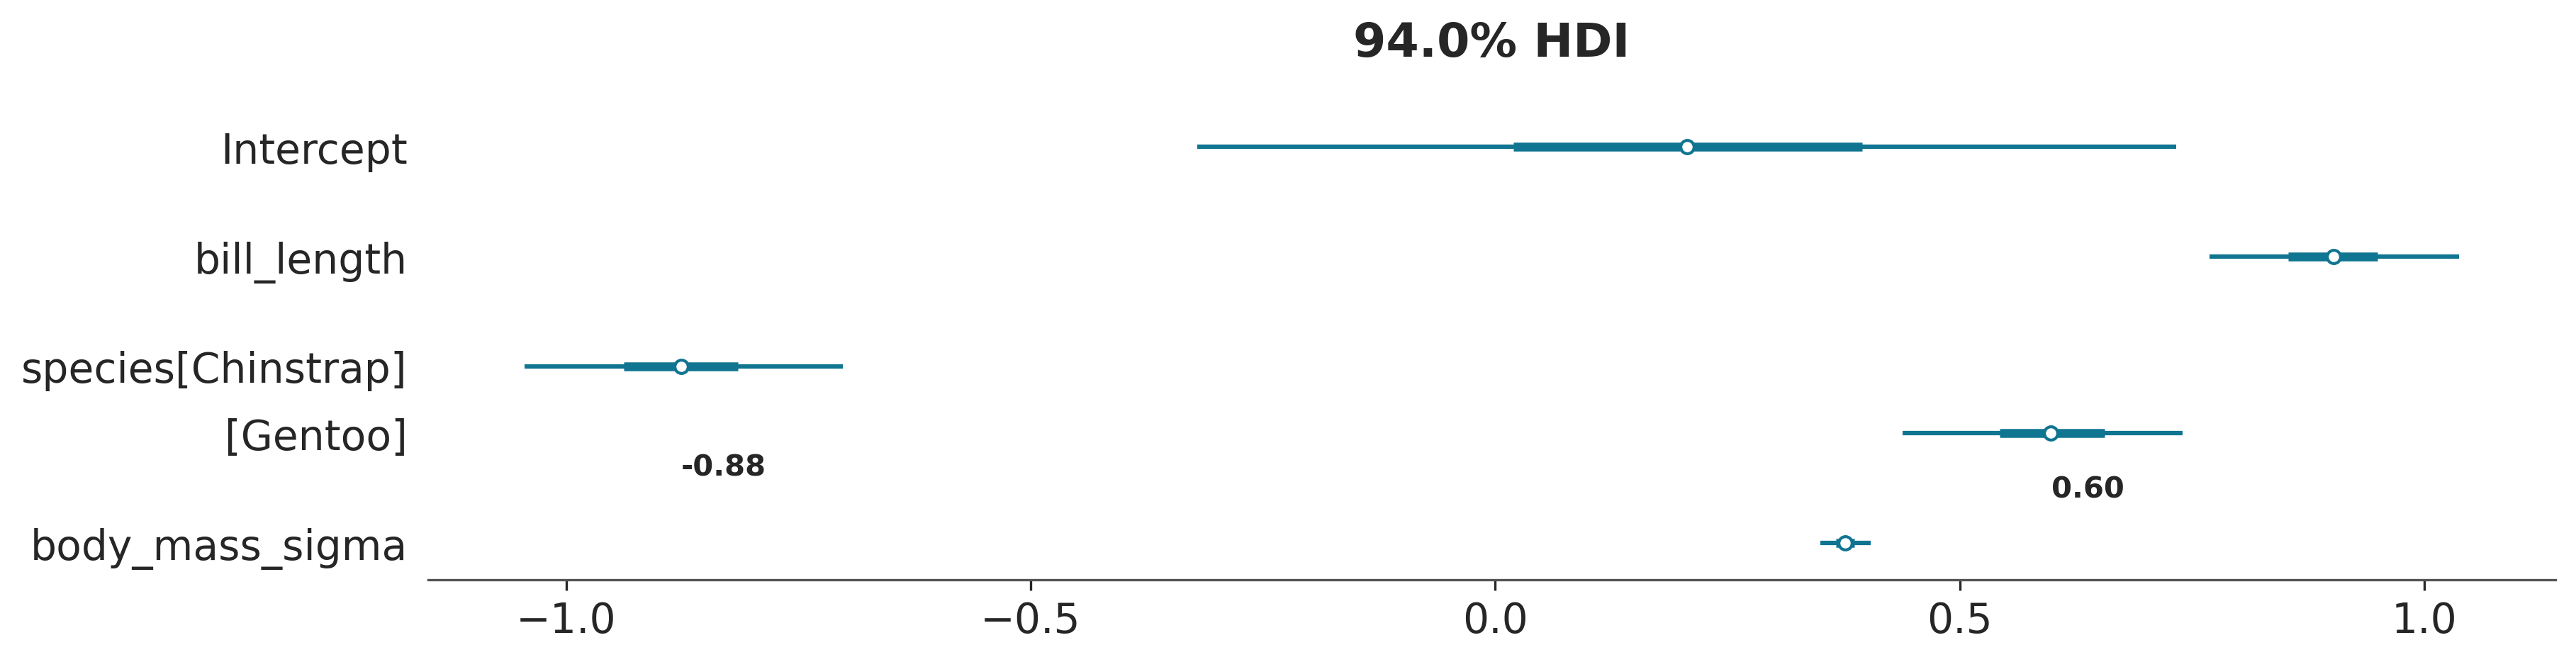

In [24]:
ax = az.plot_forest(idata_p, combined=True, figsize=(12, 3))
mean_chinstrap = idata_p.posterior["species"].sel(species_dim="Chinstrap").mean()
mean_gentoo = idata_p.posterior["species"].sel(species_dim="Gentoo").mean()
ax[0].annotate(f"{mean_chinstrap.item():.2f}", (mean_chinstrap , 2.5), weight='bold')
ax[0].annotate(f"{mean_gentoo.item():.2f}", (mean_gentoo , 1.7), weight='bold');

(<Figure size 3450x1500 with 1 Axes>,
 array([<Axes: xlabel='bill_length', ylabel='body_mass'>], dtype=object))

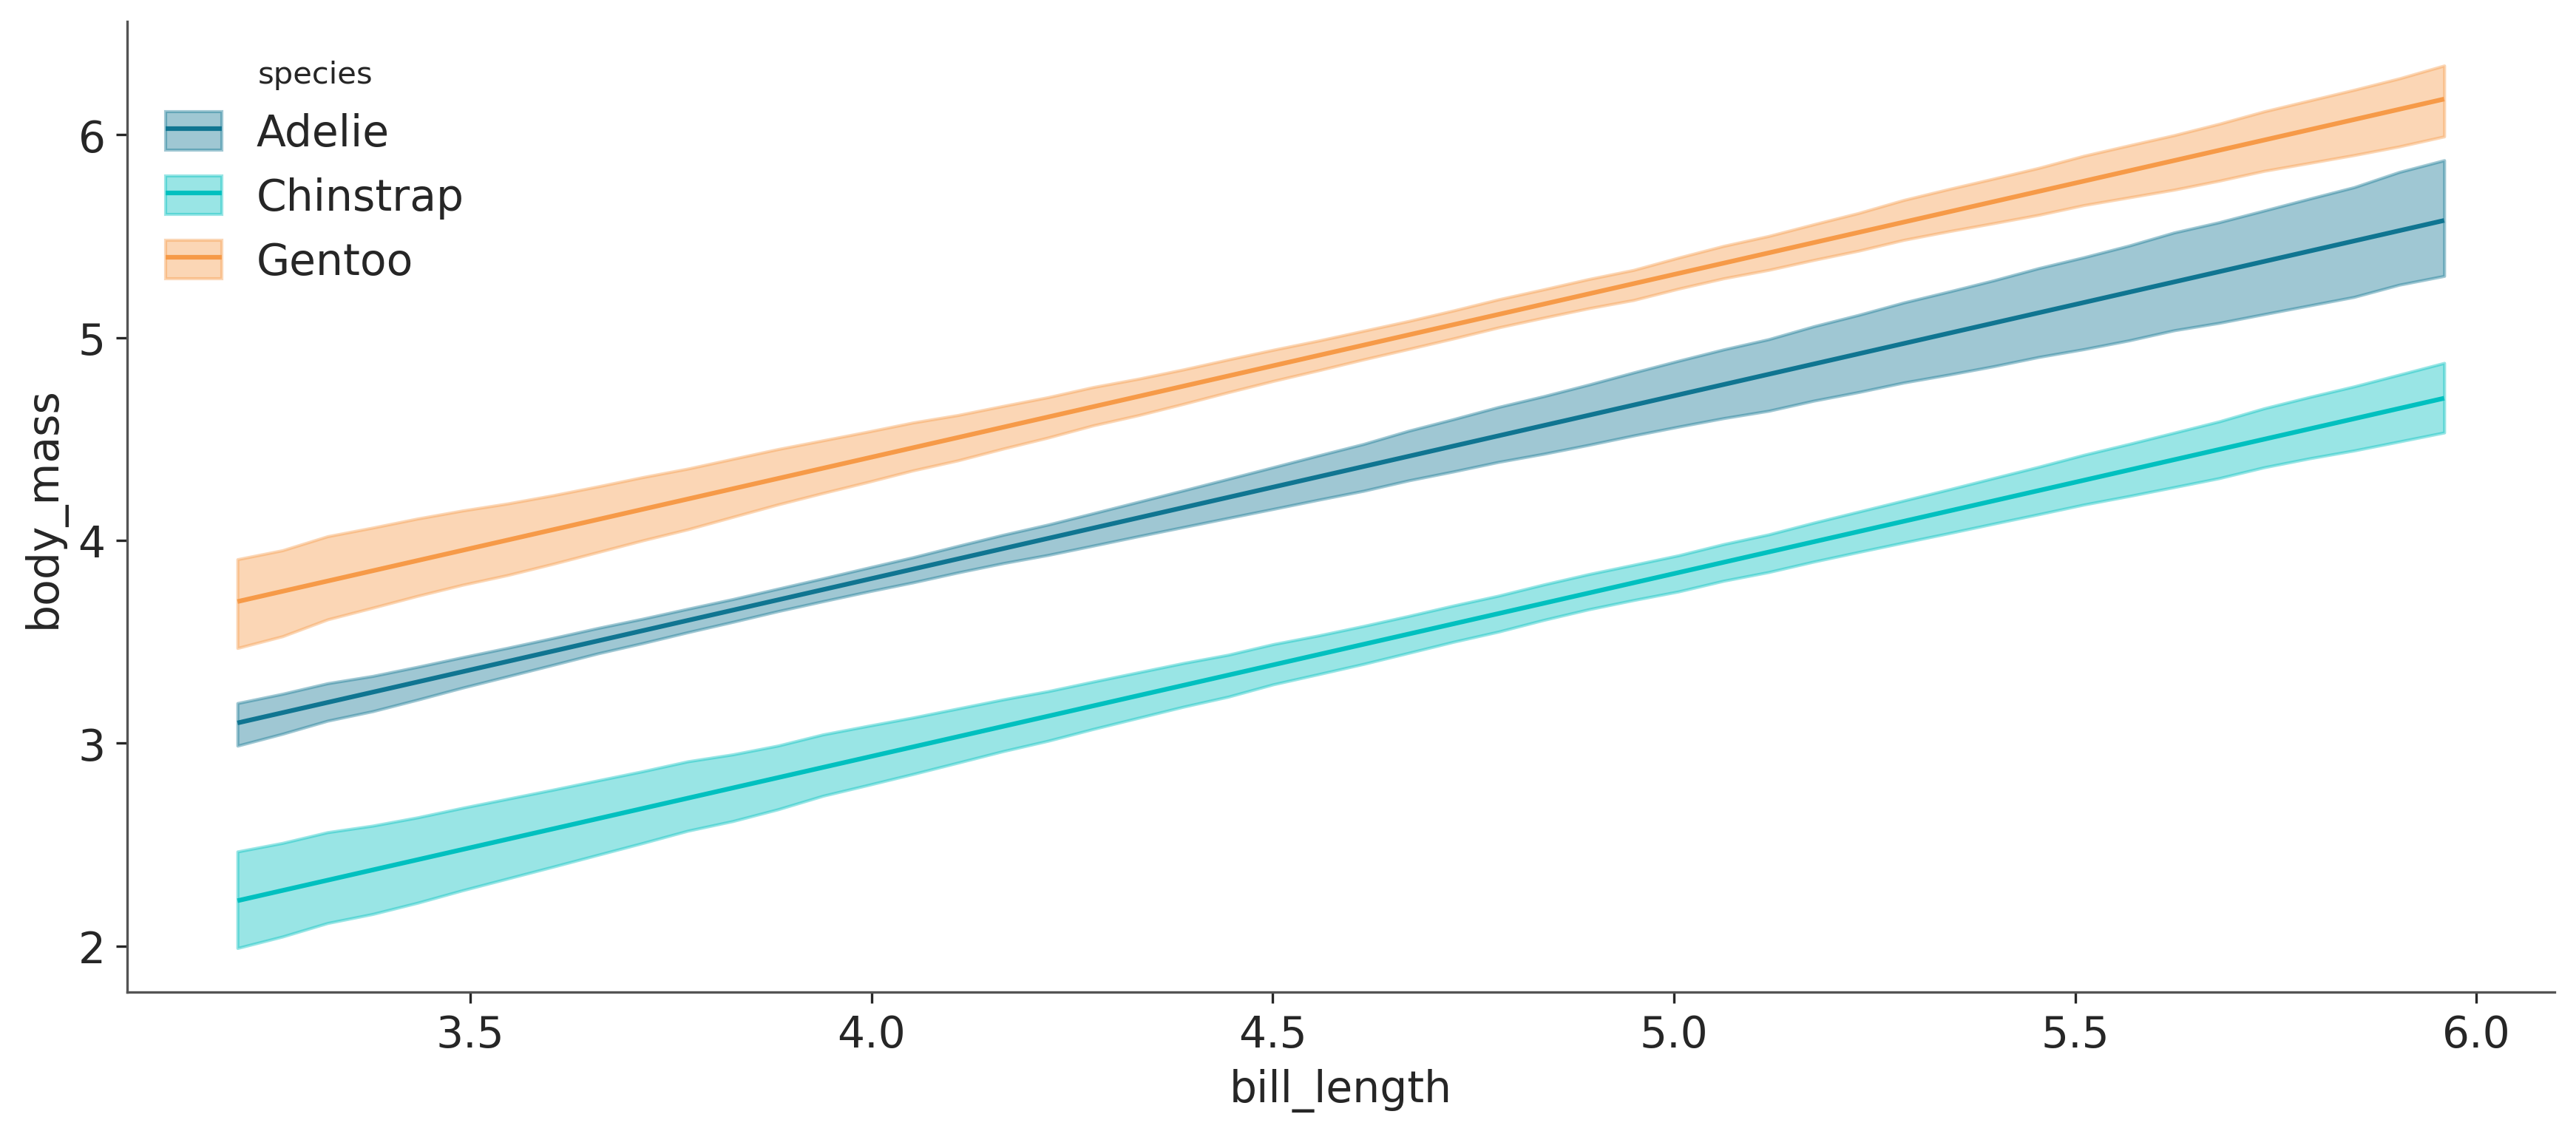

In [25]:
bmb.interpret.plot_predictions(penguins_model, idata_p, ["bill_length",  "species"])

## Interactions
- Effect of one independent variable changes depending on the value of another independent variable
- Most common way is multiplying two variables
  - $\mu = \alpha + \beta_{0}X_{0} + \beta_{1}X_{1} + \beta_{2}X_{0}X_{1}$
  - Can be rewrited as $mu=\alpha + \beta_{0}X_{0} + X_{1}(\beta_{1} + \beta_{2}X_{0})$
  - Understood as a linear model inside a linear model

In [26]:
# Without interaction
model_noint = bmb.Model("body_mass ~ bill_depth + bill_length", data=penguins)
idata_noint = model_noint.fit()

# With interaction
model_int = bmb.Model("body_mass ~ bill_depth + bill_length + bill_depth:bill_length", data=penguins)
idata_int = model_int.fit()
                    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [body_mass_sigma, Intercept, bill_depth, bill_length]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 34 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [body_mass_sigma, Intercept, bill_depth, bill_length, bill_depth:bill_length]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 55 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


c:\Users\Gabriel\mambaforge\envs\bayes\lib\site-packages\bambi\interpret\utils.py:383: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_string_dtype(x) or is_categorical_dtype(x):
c:\Users\Gabriel\mambaforge\envs\bayes\lib\site-packages\bambi\interpret\utils.py:383: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_string_dtype(x) or is_categorical_dtype(x):


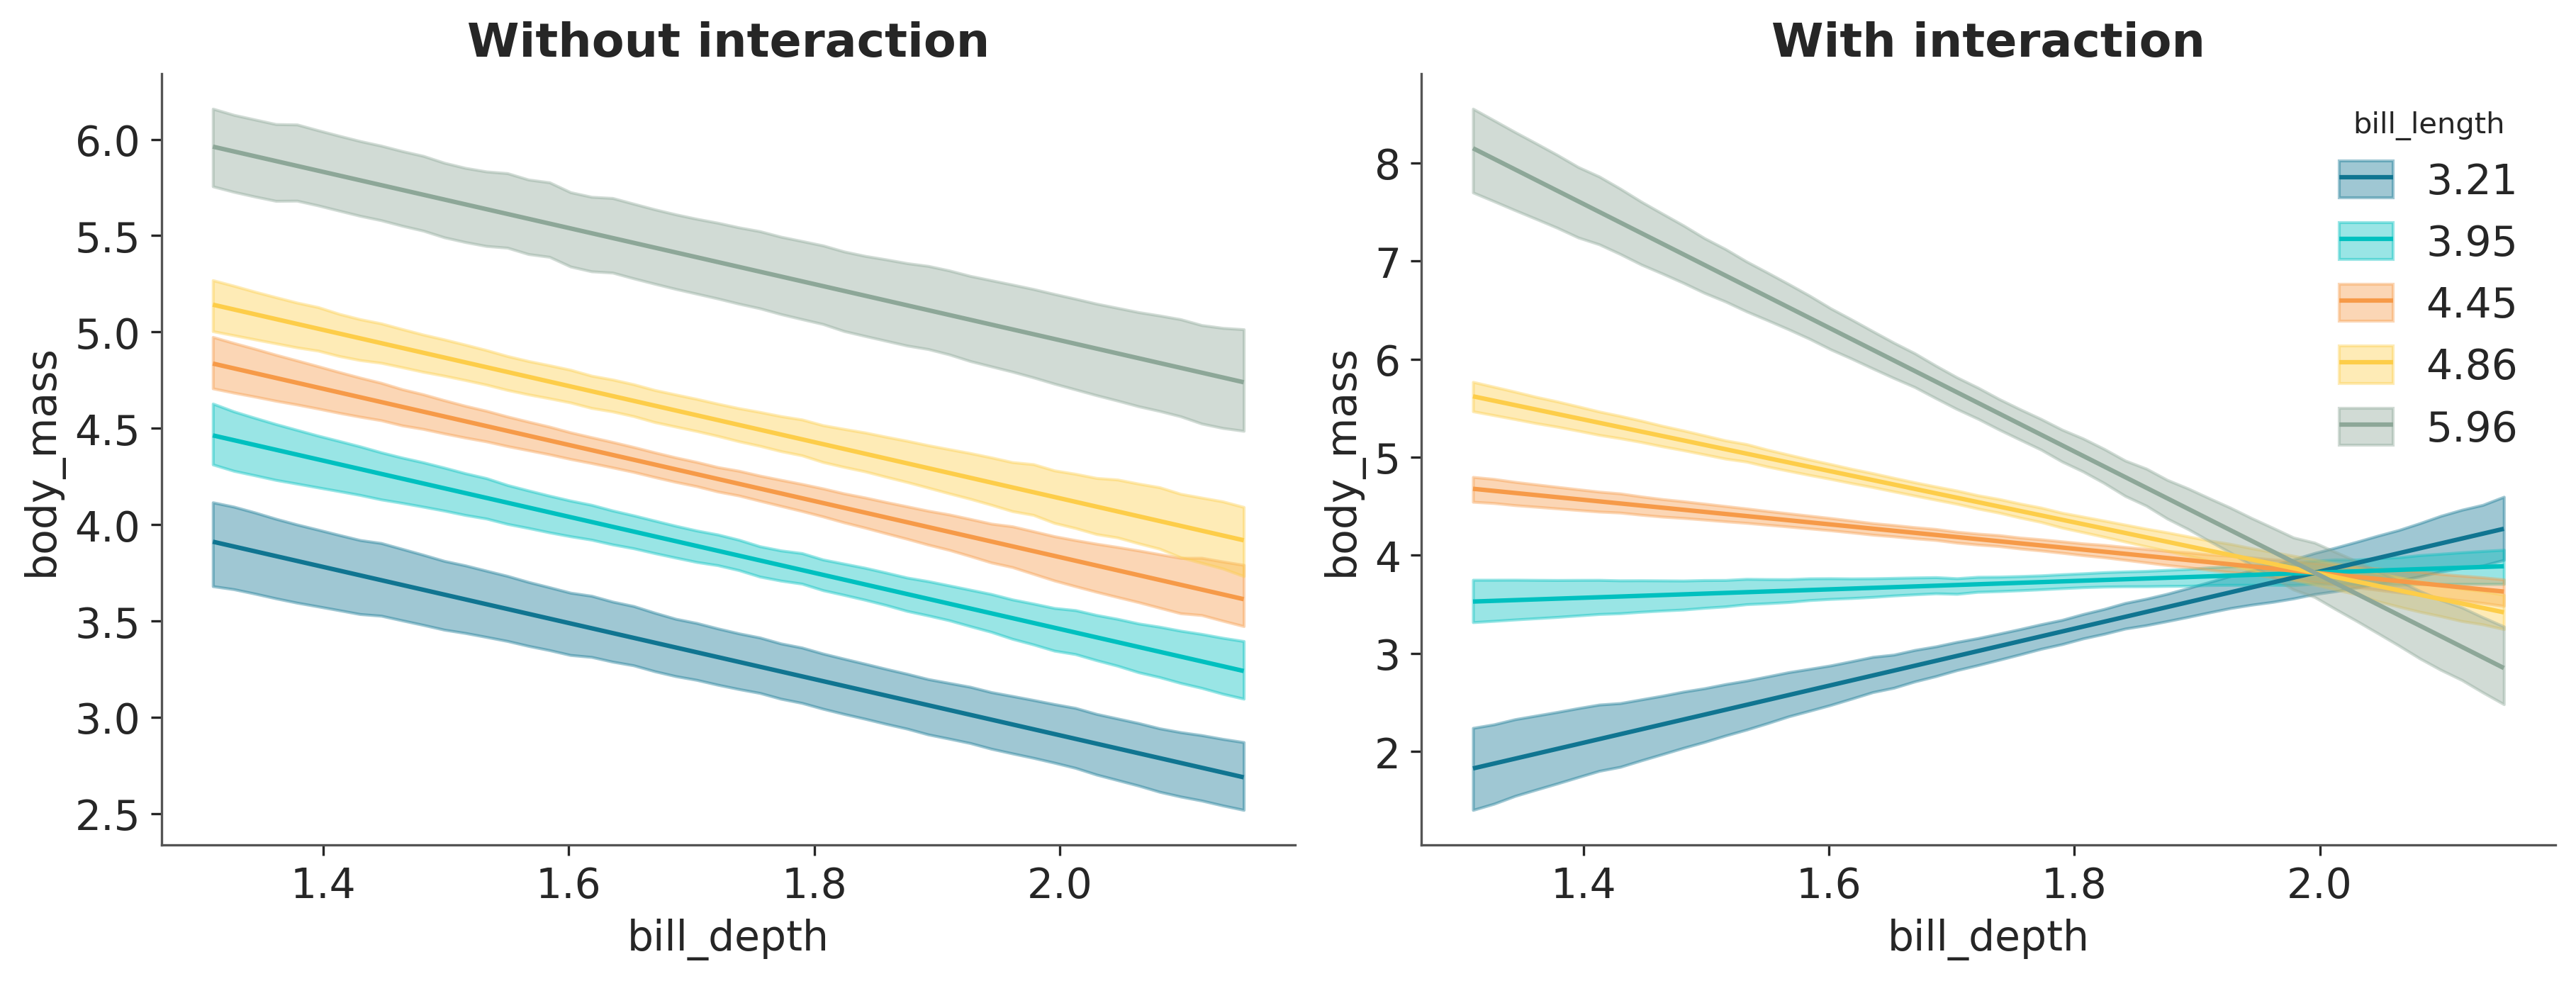

In [27]:
_, axes = plt.subplots(1, 2, figsize=(12, 4.5), gridspec_kw={'hspace': 0.1})

bmb.interpret.plot_predictions(model_noint, idata_noint,
                                ["bill_depth",  "bill_length"],
                                ax=axes[0],
                                legend=False,
                                )
axes[0].set_title("Without interaction")


bmb.interpret.plot_predictions(model_int, idata_int,
                               ["bill_depth",  "bill_length"],
                                ax=axes[1],
                                )
axes[1].set_title("With interaction");

## Interpreting models with Bambi


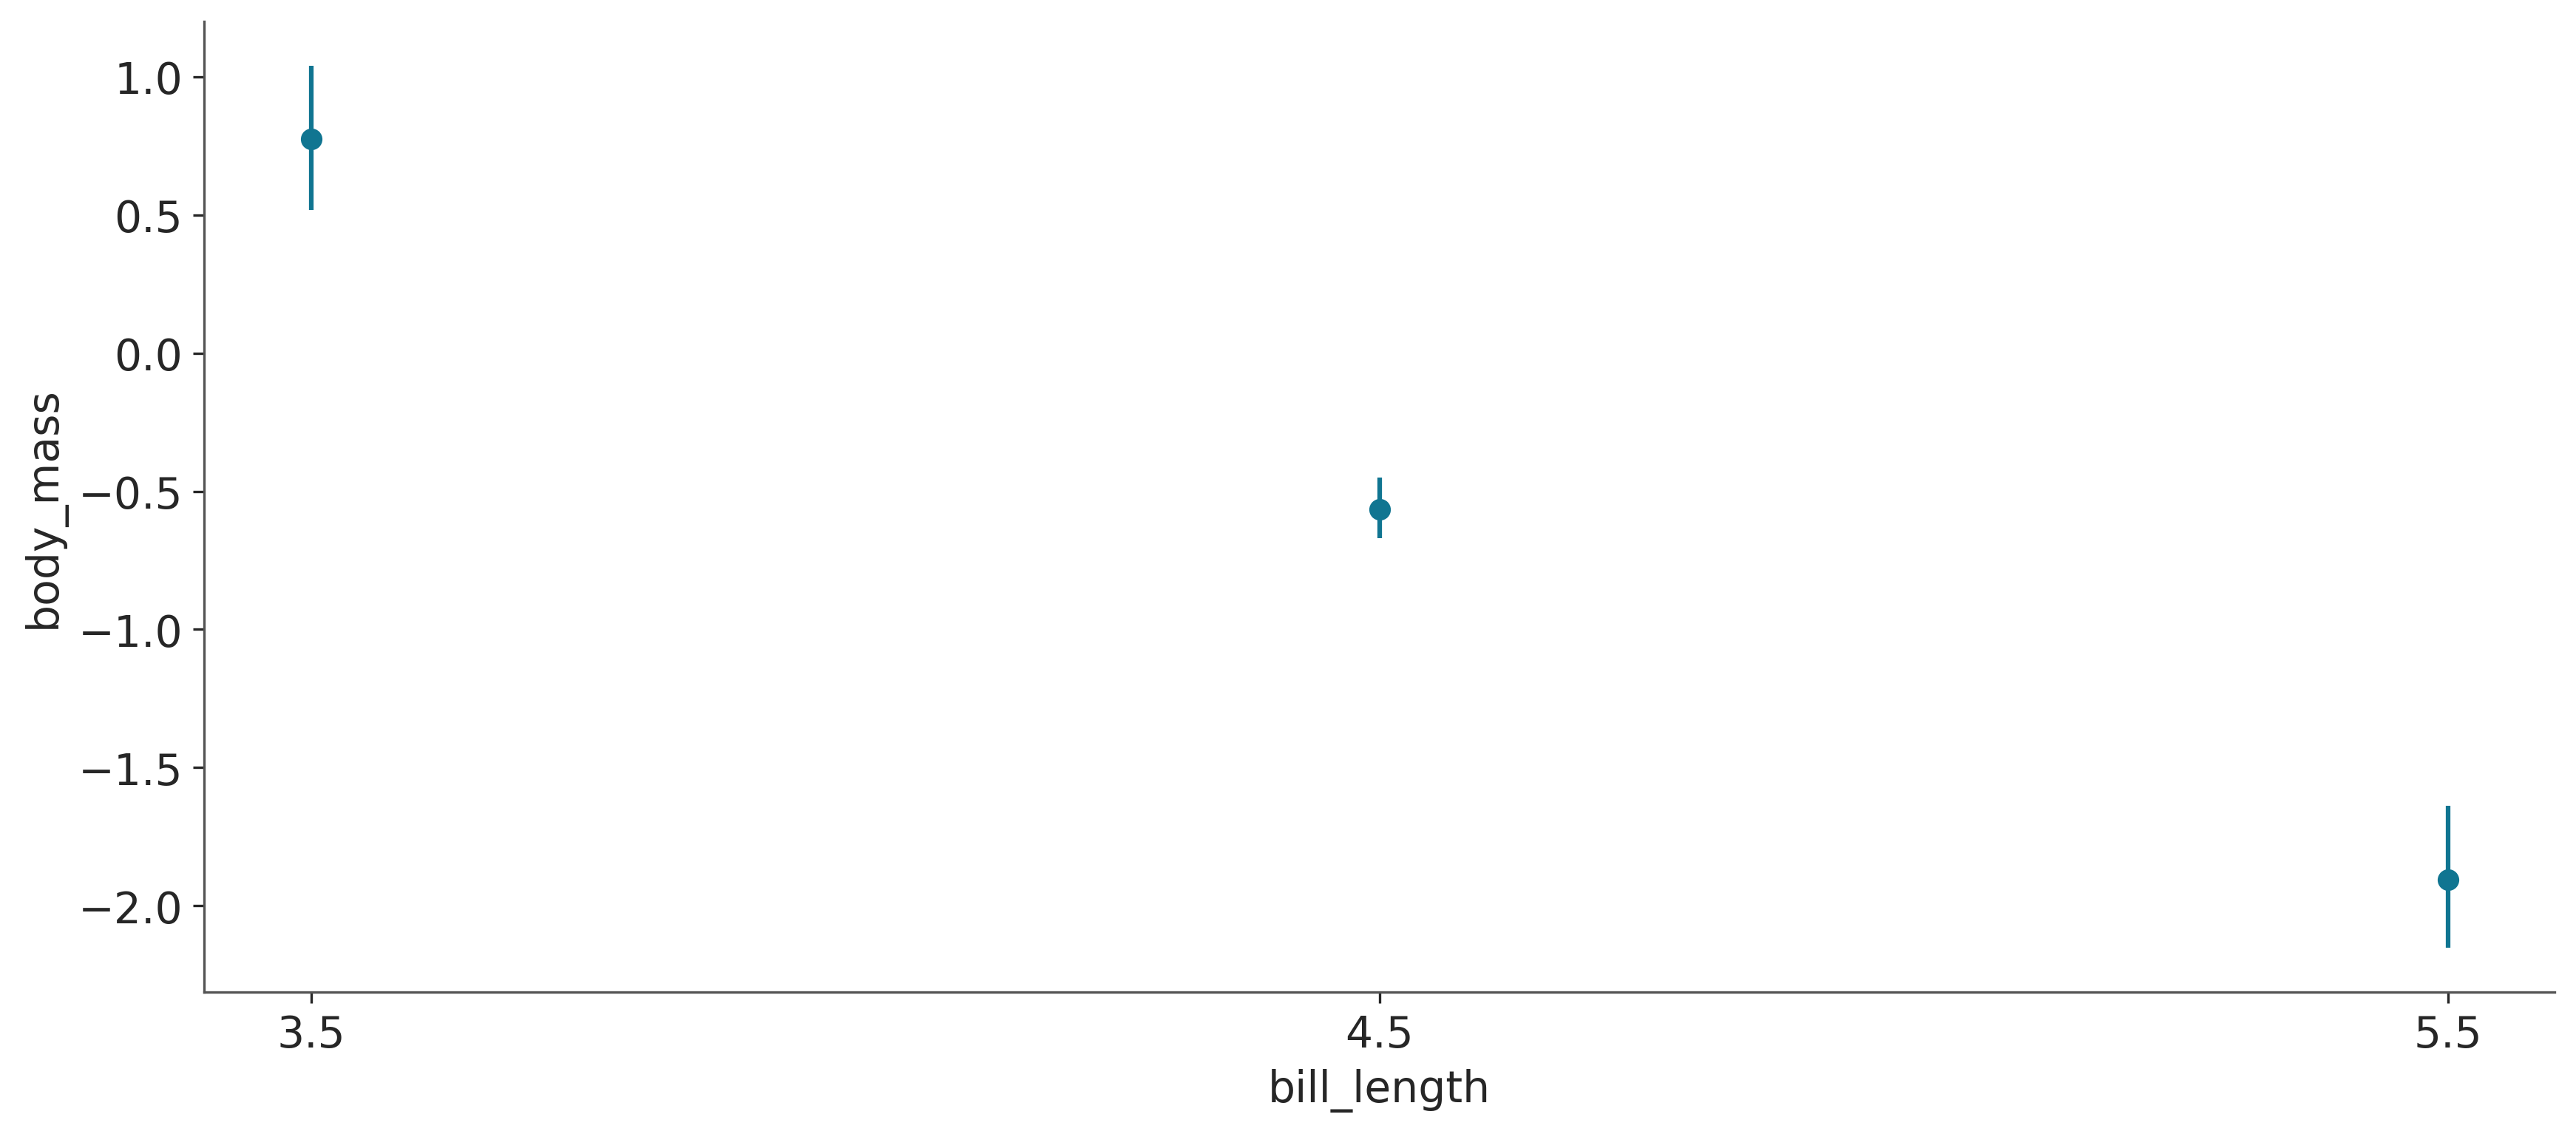

In [29]:
bmb.interpret.plot_comparisons(model_int, idata_int,
                               contrast={"bill_depth":[1.4, 1.8]},
                               conditional={"bill_length":[3.5, 4.5, 5.5]}); # Expected difference between a penguin with 1.8 and 1.4 bill depth

In [30]:
bmb.interpret.comparisons(model_int, idata_int,
                          contrast={"bill_depth":[1.4, 1.8]},
                          conditional={"bill_length":[3.5, 4.5, 5.5]})

,term,estimate_type,value,bill_length,estimate,lower_3.0%,upper_97.0%
0,bill_depth,diff,"(1.4, 1.8)",3.5,0.774377,0.517275,1.039972
1,bill_depth,diff,"(1.4, 1.8)",4.5,-0.565804,-0.670847,-0.450222
2,bill_depth,diff,"(1.4, 1.8)",5.5,-1.905985,-2.152671,-1.636718


c:\Users\Gabriel\mambaforge\envs\bayes\lib\site-packages\bambi\interpret\effects.py:841: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(model.data[wrt_name]) or is_string_dtype(model.data[wrt_name]):


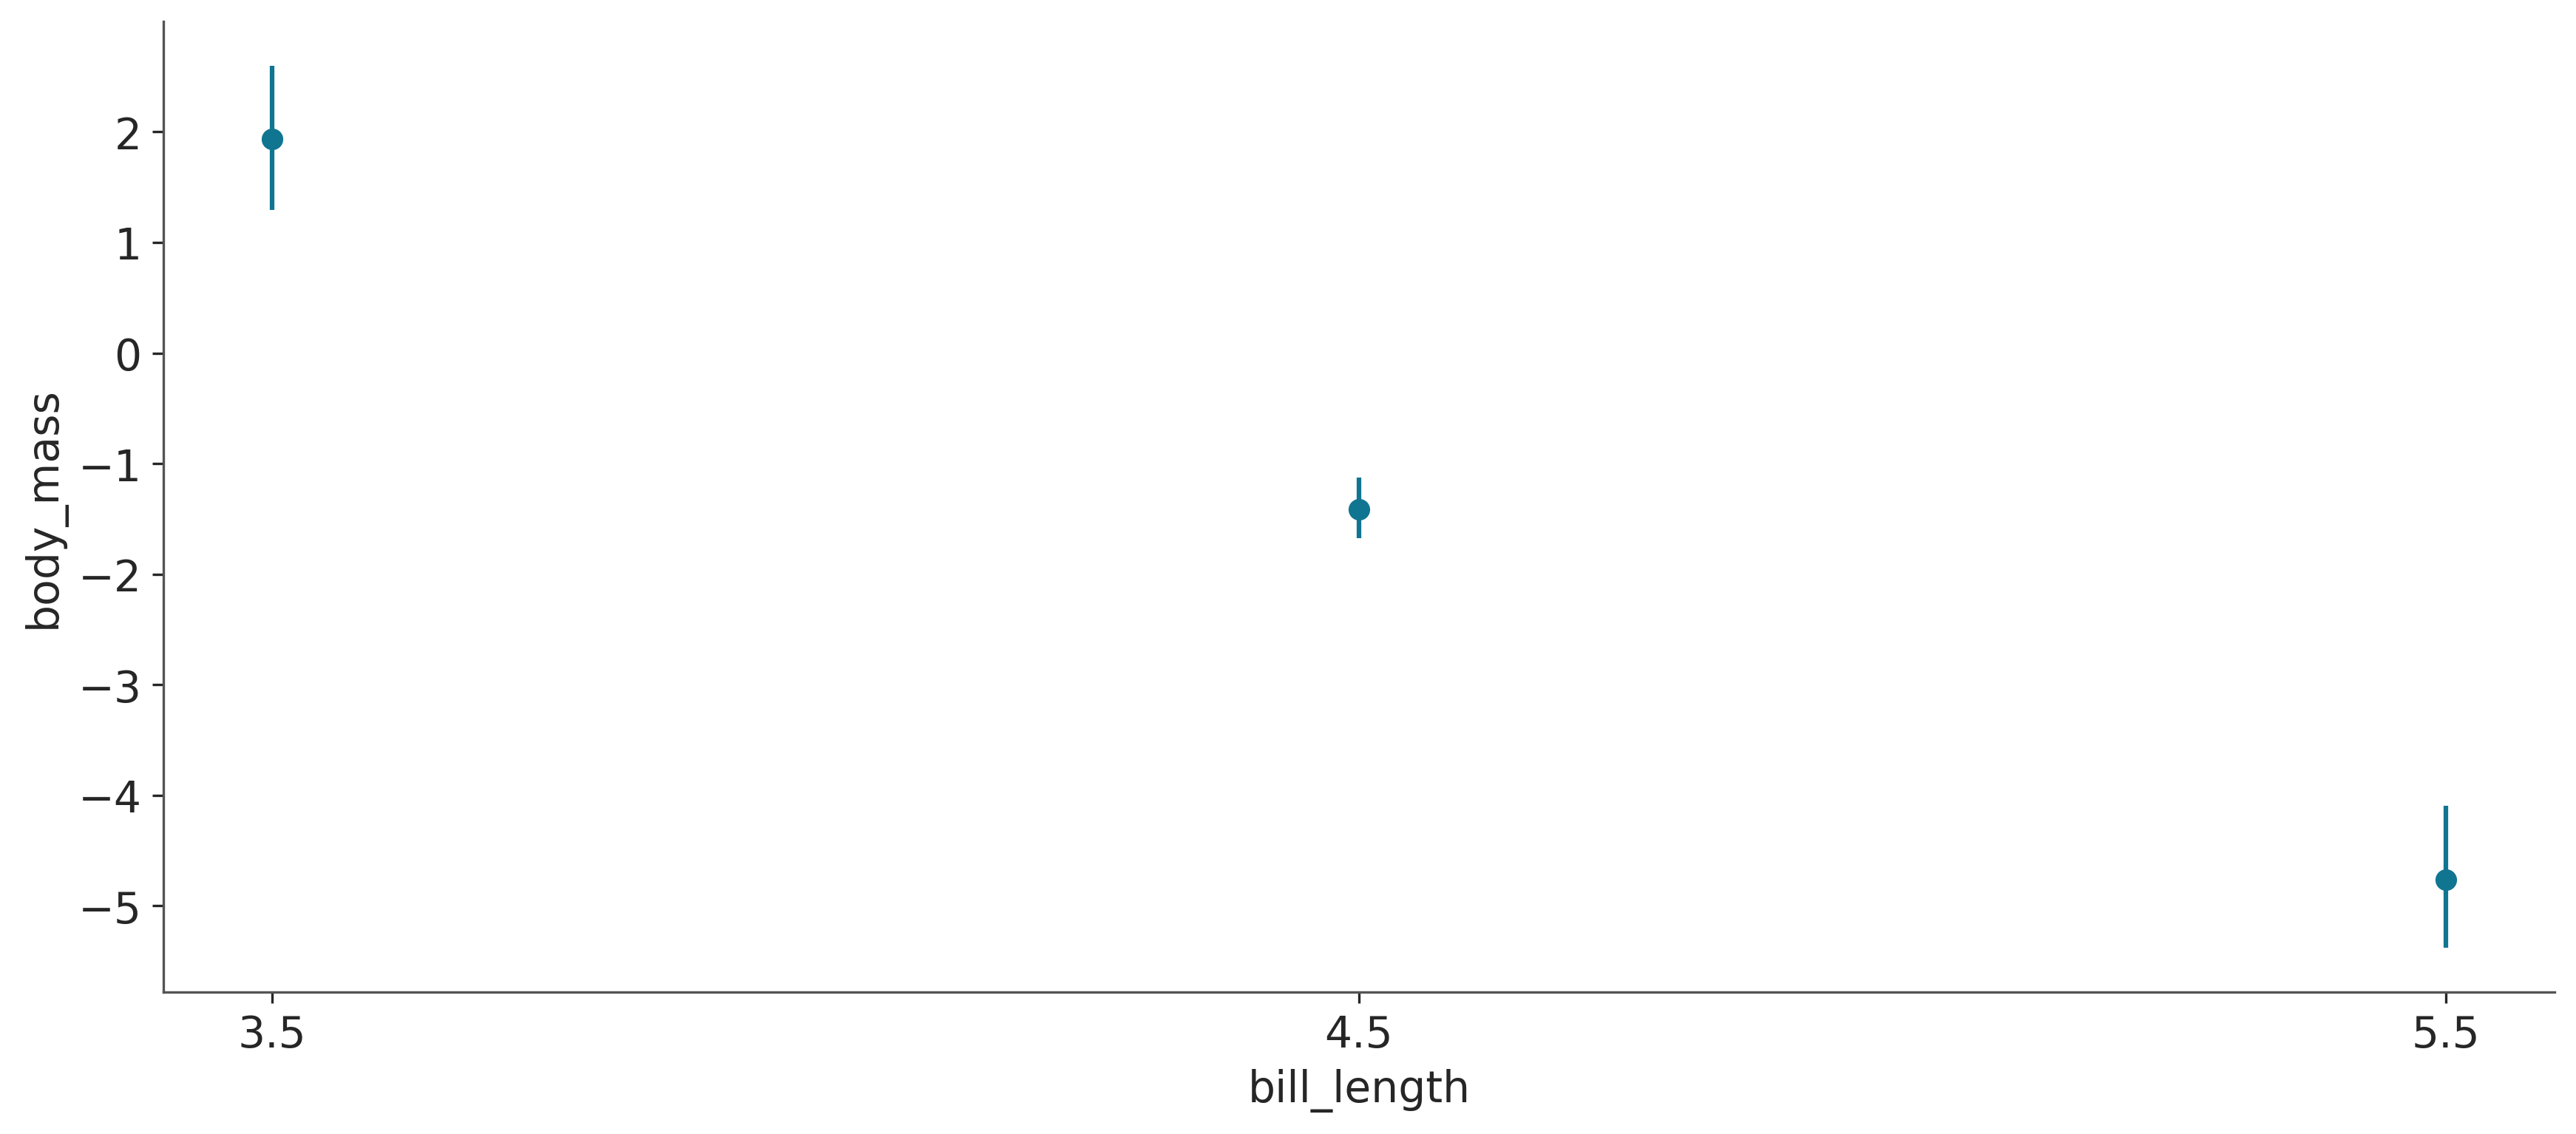

In [31]:
bmb.interpret.plot_slopes(model_int, idata_int,
                          wrt={"bill_depth":1.8},
                          conditional={"bill_length":[3.5, 4.5, 5.5]}); # slope at a given value